# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

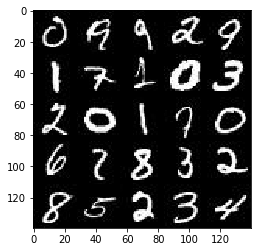

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

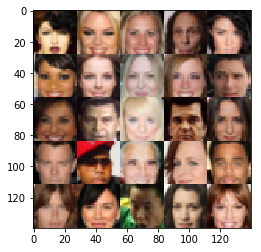

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_inputs')
    z_inputs=tf.placeholder(tf.float32,(None,z_dim),name='z_inputs')
    lr=tf.placeholder(tf.float32,name='learning_rate')

    return (real_inputs,z_inputs,lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    # images 28x28x?
    with tf.variable_scope('discriminator',reuse=reuse):
        
        #14x14x64
        x1=tf.layers.conv2d(images,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1=tf.maximum(alpha*x1,x1)
        x1=tf.nn.dropout(x1,keep_prob=0.8)

        #7x7x128
        x2=tf.layers.conv2d(x1,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2=tf.layers.batch_normalization(x2,training=True)
        x2=tf.maximum(alpha*x2,x2)
        x2=tf.nn.dropout(x2,keep_prob=0.8)
        #4x4x256
        x3=tf.layers.conv2d(x2,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3=tf.layers.batch_normalization(x3,training=True)
        x3=tf.maximum(alpha*x3,x3)
        x3=tf.nn.dropout(x3,keep_prob=0.8)
        #2x2x512
        x4=tf.layers.conv2d(x3,512,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4=tf.layers.batch_normalization(x4,training=True)
        x4=tf.maximum(alpha*x4,x4)        
        x4=tf.nn.dropout(x4,keep_prob=0.8)
        
        
        x4=tf.reshape(x4,(-1,2*2*512))
        logits=tf.layers.dense(x4,1,kernel_initializer=tf.contrib.layers.xavier_initializer())
        output=tf.sigmoid(logits)
        
    return (output,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        
        #7x7x512
        x1=tf.layers.dense(z,7*7*512,kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1=tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        #7x7x256
        x2=tf.layers.conv2d_transpose(x1,256,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2=tf.layers.batch_normalization(x2,training=is_train)
        x2=tf.maximum(alpha*x2,x2)
        
        #14x14x128
        x3=tf.layers.conv2d_transpose(x2,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3=tf.layers.batch_normalization(x3,training=is_train)
        x3=tf.maximum(alpha*x3,x3)
        
        #28x28x64
        x4=tf.layers.conv2d_transpose(x3,64,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4=tf.layers.batch_normalization(x4,training=is_train)
        x4=tf.maximum(alpha*x4,x4)
               
        #28x28x?
        logits=tf.layers.conv2d_transpose(x4,out_channel_dim,5,strides=1,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        out=tf.tanh(logits)
        
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth=0.1
    # TODO: Implement Function
    g_model=generator(input_z,out_channel_dim)
    d_model_real, d_logits_real=discriminator(input_real)
    d_model_fake, d_logits_fake=discriminator(g_model,reuse=True)
    
    d_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))
    
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_logits_fake)))
    
    d_loss=d_loss_real+d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_var=tf.trainable_variables()
    d_var=[var for var in t_var if var.name.startswith('discriminator')]
    g_var=[var for var in t_var if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_var)
        g_train_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_var)
    
    
    return (d_train_opt,g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_images=25
    
    if data_image_mode=='RGB':
        out_channel_dim=3
    elif data_image_mode=='L':
        out_channel_dim=1
        
    input_real,input_z,lr=model_inputs(data_shape[1],data_shape[2],out_channel_dim,z_dim)
    
    d_loss,g_loss=model_loss(input_real,input_z,out_channel_dim)
    
    d_train_opt,g_train_opt=model_opt(d_loss,g_loss,lr,beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps=0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images=batch_images*2
                
                steps+=1
                
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                _ =sess.run(g_train_opt,feed_dict={input_z:batch_z,input_real:batch_images,lr:learning_rate})
                _ =sess.run(d_train_opt,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})
                
                if steps % 20 ==0:
                    train_loss_d=d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g=g_loss.eval({input_z:batch_z})
                
                    print("Epoch {}/{}---".format(epoch_i,epoch_count),'Batch {}----'.format(steps),'Discriminator loss: {:.4f}---'.format(train_loss_d),'Generator loss: {:.4f}---'.format(train_loss_g))
                
                if steps%100==0:
                    
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2--- Batch 20---- Discriminator loss: 0.8448--- Generator loss: 4.7526---
Epoch 0/2--- Batch 40---- Discriminator loss: 0.4460--- Generator loss: 4.0616---
Epoch 0/2--- Batch 60---- Discriminator loss: 0.9996--- Generator loss: 2.6199---
Epoch 0/2--- Batch 80---- Discriminator loss: 1.0445--- Generator loss: 1.0361---
Epoch 0/2--- Batch 100---- Discriminator loss: 1.2667--- Generator loss: 1.3076---


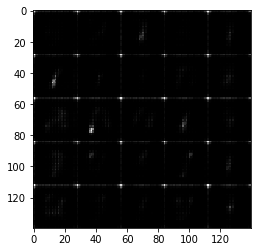

Epoch 0/2--- Batch 120---- Discriminator loss: 1.2130--- Generator loss: 1.8190---
Epoch 0/2--- Batch 140---- Discriminator loss: 1.2580--- Generator loss: 1.3341---
Epoch 0/2--- Batch 160---- Discriminator loss: 1.2860--- Generator loss: 0.7096---
Epoch 0/2--- Batch 180---- Discriminator loss: 1.3763--- Generator loss: 1.6431---
Epoch 0/2--- Batch 200---- Discriminator loss: 1.1629--- Generator loss: 1.0820---


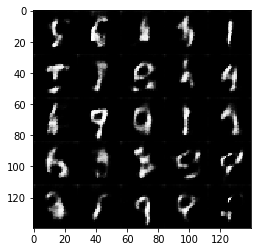

Epoch 0/2--- Batch 220---- Discriminator loss: 1.2339--- Generator loss: 1.3006---
Epoch 0/2--- Batch 240---- Discriminator loss: 1.2805--- Generator loss: 1.2967---
Epoch 0/2--- Batch 260---- Discriminator loss: 1.3004--- Generator loss: 0.8776---
Epoch 0/2--- Batch 280---- Discriminator loss: 1.2131--- Generator loss: 0.8791---
Epoch 0/2--- Batch 300---- Discriminator loss: 1.1737--- Generator loss: 0.9246---


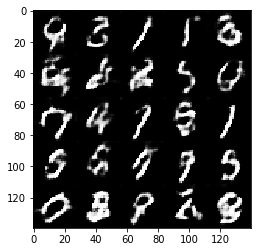

Epoch 0/2--- Batch 320---- Discriminator loss: 1.2719--- Generator loss: 1.1836---
Epoch 0/2--- Batch 340---- Discriminator loss: 1.3219--- Generator loss: 0.6667---
Epoch 0/2--- Batch 360---- Discriminator loss: 1.3085--- Generator loss: 0.8531---
Epoch 0/2--- Batch 380---- Discriminator loss: 1.2666--- Generator loss: 0.9160---
Epoch 0/2--- Batch 400---- Discriminator loss: 1.2834--- Generator loss: 0.7848---


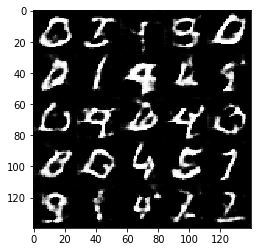

Epoch 0/2--- Batch 420---- Discriminator loss: 1.3180--- Generator loss: 0.9134---
Epoch 0/2--- Batch 440---- Discriminator loss: 1.2948--- Generator loss: 0.6669---
Epoch 0/2--- Batch 460---- Discriminator loss: 1.2626--- Generator loss: 1.2931---
Epoch 0/2--- Batch 480---- Discriminator loss: 1.2301--- Generator loss: 1.0736---
Epoch 0/2--- Batch 500---- Discriminator loss: 1.2654--- Generator loss: 1.0671---


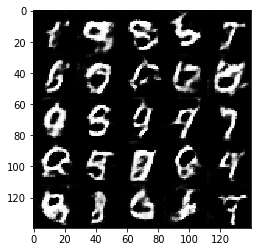

Epoch 0/2--- Batch 520---- Discriminator loss: 1.2081--- Generator loss: 0.9848---
Epoch 0/2--- Batch 540---- Discriminator loss: 1.2622--- Generator loss: 0.6707---
Epoch 0/2--- Batch 560---- Discriminator loss: 1.2334--- Generator loss: 0.8091---
Epoch 0/2--- Batch 580---- Discriminator loss: 1.1789--- Generator loss: 0.9418---
Epoch 0/2--- Batch 600---- Discriminator loss: 1.2592--- Generator loss: 0.8073---


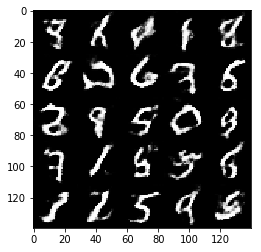

Epoch 0/2--- Batch 620---- Discriminator loss: 1.2081--- Generator loss: 0.8403---
Epoch 0/2--- Batch 640---- Discriminator loss: 1.4169--- Generator loss: 1.6203---
Epoch 0/2--- Batch 660---- Discriminator loss: 1.1432--- Generator loss: 1.2621---
Epoch 0/2--- Batch 680---- Discriminator loss: 1.2220--- Generator loss: 1.1931---
Epoch 0/2--- Batch 700---- Discriminator loss: 1.2052--- Generator loss: 1.0747---


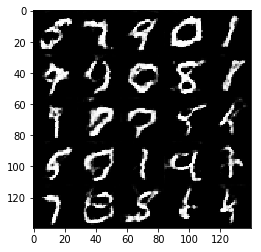

Epoch 0/2--- Batch 720---- Discriminator loss: 1.1776--- Generator loss: 0.9710---
Epoch 0/2--- Batch 740---- Discriminator loss: 1.1861--- Generator loss: 0.9886---
Epoch 0/2--- Batch 760---- Discriminator loss: 1.1876--- Generator loss: 0.8394---
Epoch 0/2--- Batch 780---- Discriminator loss: 1.2477--- Generator loss: 0.9737---
Epoch 0/2--- Batch 800---- Discriminator loss: 1.2471--- Generator loss: 1.0119---


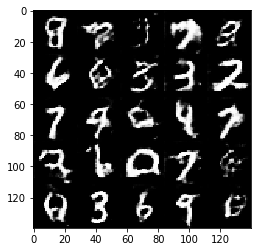

Epoch 0/2--- Batch 820---- Discriminator loss: 1.2062--- Generator loss: 0.9448---
Epoch 0/2--- Batch 840---- Discriminator loss: 1.2721--- Generator loss: 0.7290---
Epoch 0/2--- Batch 860---- Discriminator loss: 1.2506--- Generator loss: 0.8199---
Epoch 0/2--- Batch 880---- Discriminator loss: 1.1456--- Generator loss: 1.0266---
Epoch 0/2--- Batch 900---- Discriminator loss: 1.1875--- Generator loss: 1.0235---


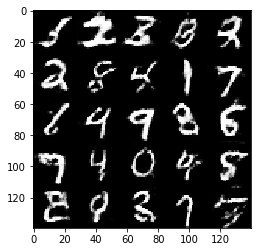

Epoch 0/2--- Batch 920---- Discriminator loss: 1.2094--- Generator loss: 1.0501---
Epoch 1/2--- Batch 20---- Discriminator loss: 1.1560--- Generator loss: 1.0817---
Epoch 1/2--- Batch 40---- Discriminator loss: 1.2534--- Generator loss: 0.9731---
Epoch 1/2--- Batch 60---- Discriminator loss: 1.1978--- Generator loss: 1.0213---
Epoch 1/2--- Batch 80---- Discriminator loss: 1.2282--- Generator loss: 0.8637---
Epoch 1/2--- Batch 100---- Discriminator loss: 1.2304--- Generator loss: 1.1978---


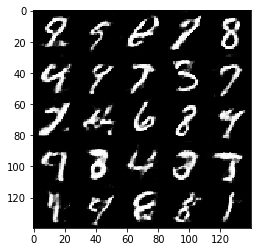

Epoch 1/2--- Batch 120---- Discriminator loss: 1.3876--- Generator loss: 0.6074---
Epoch 1/2--- Batch 140---- Discriminator loss: 1.2300--- Generator loss: 0.8246---
Epoch 1/2--- Batch 160---- Discriminator loss: 1.2930--- Generator loss: 0.9405---
Epoch 1/2--- Batch 180---- Discriminator loss: 1.2924--- Generator loss: 0.7381---
Epoch 1/2--- Batch 200---- Discriminator loss: 1.1721--- Generator loss: 0.9860---


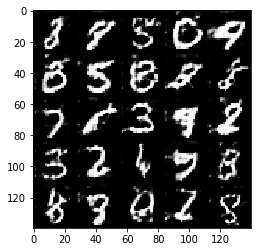

Epoch 1/2--- Batch 220---- Discriminator loss: 1.2734--- Generator loss: 0.9551---
Epoch 1/2--- Batch 240---- Discriminator loss: 1.2293--- Generator loss: 1.2020---
Epoch 1/2--- Batch 260---- Discriminator loss: 1.2141--- Generator loss: 0.9775---
Epoch 1/2--- Batch 280---- Discriminator loss: 1.1487--- Generator loss: 0.9698---
Epoch 1/2--- Batch 300---- Discriminator loss: 1.2597--- Generator loss: 0.7559---


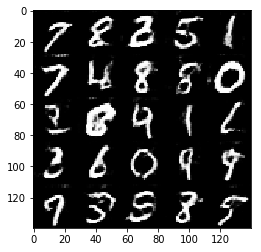

Epoch 1/2--- Batch 320---- Discriminator loss: 1.2124--- Generator loss: 0.9661---
Epoch 1/2--- Batch 340---- Discriminator loss: 1.2792--- Generator loss: 0.8986---
Epoch 1/2--- Batch 360---- Discriminator loss: 1.1812--- Generator loss: 0.9818---
Epoch 1/2--- Batch 380---- Discriminator loss: 1.1932--- Generator loss: 1.0955---
Epoch 1/2--- Batch 400---- Discriminator loss: 1.2258--- Generator loss: 0.9292---


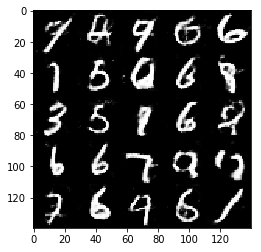

Epoch 1/2--- Batch 420---- Discriminator loss: 1.2897--- Generator loss: 1.1508---
Epoch 1/2--- Batch 440---- Discriminator loss: 1.1805--- Generator loss: 0.8890---
Epoch 1/2--- Batch 460---- Discriminator loss: 1.2901--- Generator loss: 1.0964---
Epoch 1/2--- Batch 480---- Discriminator loss: 1.1268--- Generator loss: 0.9624---
Epoch 1/2--- Batch 500---- Discriminator loss: 1.2164--- Generator loss: 0.9771---


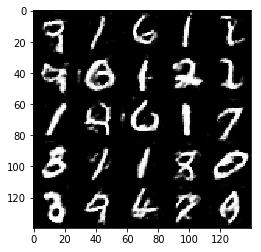

Epoch 1/2--- Batch 520---- Discriminator loss: 1.1967--- Generator loss: 0.9341---
Epoch 1/2--- Batch 540---- Discriminator loss: 1.2084--- Generator loss: 0.8981---
Epoch 1/2--- Batch 560---- Discriminator loss: 1.2206--- Generator loss: 0.9505---
Epoch 1/2--- Batch 580---- Discriminator loss: 1.1324--- Generator loss: 0.9209---
Epoch 1/2--- Batch 600---- Discriminator loss: 1.2219--- Generator loss: 0.6662---


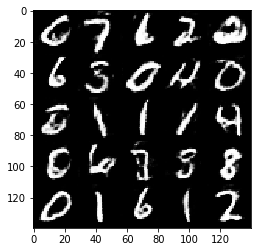

Epoch 1/2--- Batch 620---- Discriminator loss: 1.2385--- Generator loss: 0.9101---
Epoch 1/2--- Batch 640---- Discriminator loss: 1.2649--- Generator loss: 1.0965---
Epoch 1/2--- Batch 660---- Discriminator loss: 1.2467--- Generator loss: 0.7940---
Epoch 1/2--- Batch 680---- Discriminator loss: 1.2731--- Generator loss: 1.0070---
Epoch 1/2--- Batch 700---- Discriminator loss: 1.2700--- Generator loss: 0.9047---


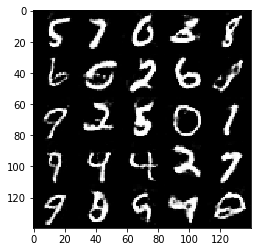

Epoch 1/2--- Batch 720---- Discriminator loss: 1.2392--- Generator loss: 1.0967---
Epoch 1/2--- Batch 740---- Discriminator loss: 1.2105--- Generator loss: 0.9722---
Epoch 1/2--- Batch 760---- Discriminator loss: 1.2147--- Generator loss: 0.8431---
Epoch 1/2--- Batch 780---- Discriminator loss: 1.3493--- Generator loss: 0.6832---
Epoch 1/2--- Batch 800---- Discriminator loss: 1.2021--- Generator loss: 0.8654---


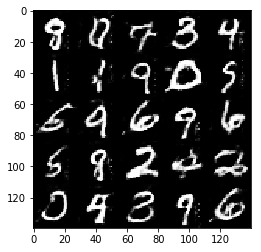

Epoch 1/2--- Batch 820---- Discriminator loss: 1.1613--- Generator loss: 1.0228---
Epoch 1/2--- Batch 840---- Discriminator loss: 1.2768--- Generator loss: 0.9146---
Epoch 1/2--- Batch 860---- Discriminator loss: 1.2116--- Generator loss: 0.8751---
Epoch 1/2--- Batch 880---- Discriminator loss: 1.2408--- Generator loss: 1.0954---
Epoch 1/2--- Batch 900---- Discriminator loss: 1.2883--- Generator loss: 1.1126---


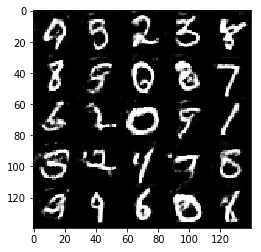

Epoch 1/2--- Batch 920---- Discriminator loss: 1.2406--- Generator loss: 0.8569---


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1--- Batch 20---- Discriminator loss: 0.4520--- Generator loss: 4.5476---
Epoch 0/1--- Batch 40---- Discriminator loss: 0.7353--- Generator loss: 3.1555---
Epoch 0/1--- Batch 60---- Discriminator loss: 1.0738--- Generator loss: 2.5550---
Epoch 0/1--- Batch 80---- Discriminator loss: 2.4248--- Generator loss: 4.1931---
Epoch 0/1--- Batch 100---- Discriminator loss: 0.9526--- Generator loss: 2.8474---


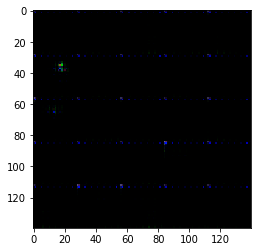

Epoch 0/1--- Batch 120---- Discriminator loss: 1.5417--- Generator loss: 3.5065---
Epoch 0/1--- Batch 140---- Discriminator loss: 1.8325--- Generator loss: 3.2596---
Epoch 0/1--- Batch 160---- Discriminator loss: 0.9649--- Generator loss: 1.4278---
Epoch 0/1--- Batch 180---- Discriminator loss: 1.1375--- Generator loss: 1.5823---
Epoch 0/1--- Batch 200---- Discriminator loss: 1.2512--- Generator loss: 1.1068---


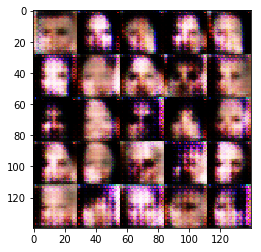

Epoch 0/1--- Batch 220---- Discriminator loss: 1.0446--- Generator loss: 1.0395---
Epoch 0/1--- Batch 240---- Discriminator loss: 1.4793--- Generator loss: 1.2504---
Epoch 0/1--- Batch 260---- Discriminator loss: 1.5130--- Generator loss: 0.6478---
Epoch 0/1--- Batch 280---- Discriminator loss: 1.4532--- Generator loss: 1.1077---
Epoch 0/1--- Batch 300---- Discriminator loss: 1.2152--- Generator loss: 0.8357---


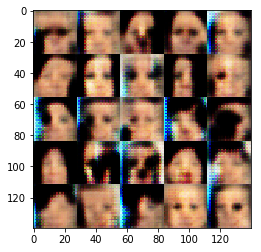

Epoch 0/1--- Batch 320---- Discriminator loss: 1.4061--- Generator loss: 0.8348---
Epoch 0/1--- Batch 340---- Discriminator loss: 1.3911--- Generator loss: 1.0052---
Epoch 0/1--- Batch 360---- Discriminator loss: 1.3994--- Generator loss: 0.9836---
Epoch 0/1--- Batch 380---- Discriminator loss: 1.3069--- Generator loss: 0.7993---
Epoch 0/1--- Batch 400---- Discriminator loss: 1.3212--- Generator loss: 0.8385---


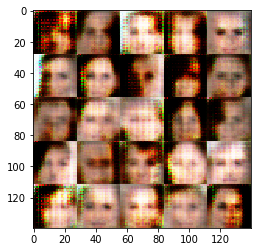

Epoch 0/1--- Batch 420---- Discriminator loss: 1.3878--- Generator loss: 1.0699---
Epoch 0/1--- Batch 440---- Discriminator loss: 1.3313--- Generator loss: 1.0756---
Epoch 0/1--- Batch 460---- Discriminator loss: 1.2837--- Generator loss: 0.8824---
Epoch 0/1--- Batch 480---- Discriminator loss: 1.2257--- Generator loss: 0.8746---
Epoch 0/1--- Batch 500---- Discriminator loss: 1.2535--- Generator loss: 0.7605---


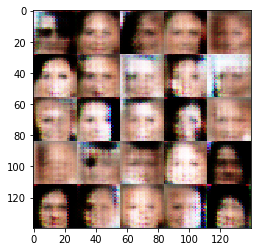

Epoch 0/1--- Batch 520---- Discriminator loss: 1.2156--- Generator loss: 0.9698---
Epoch 0/1--- Batch 540---- Discriminator loss: 1.1442--- Generator loss: 1.1320---
Epoch 0/1--- Batch 560---- Discriminator loss: 1.0529--- Generator loss: 1.2577---
Epoch 0/1--- Batch 580---- Discriminator loss: 1.2100--- Generator loss: 0.8781---
Epoch 0/1--- Batch 600---- Discriminator loss: 1.3396--- Generator loss: 2.0961---


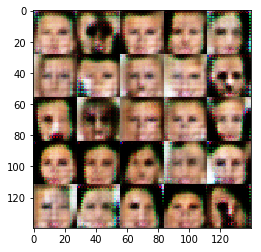

Epoch 0/1--- Batch 620---- Discriminator loss: 1.3126--- Generator loss: 1.7356---
Epoch 0/1--- Batch 640---- Discriminator loss: 1.1557--- Generator loss: 1.1513---
Epoch 0/1--- Batch 660---- Discriminator loss: 1.1845--- Generator loss: 1.0871---
Epoch 0/1--- Batch 680---- Discriminator loss: 0.9637--- Generator loss: 1.0070---
Epoch 0/1--- Batch 700---- Discriminator loss: 1.1804--- Generator loss: 1.0031---


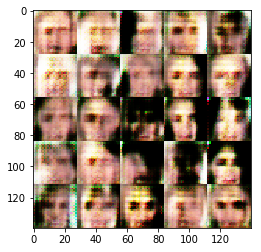

Epoch 0/1--- Batch 720---- Discriminator loss: 0.9526--- Generator loss: 1.2654---
Epoch 0/1--- Batch 740---- Discriminator loss: 1.1730--- Generator loss: 0.8214---
Epoch 0/1--- Batch 760---- Discriminator loss: 1.0676--- Generator loss: 0.9701---
Epoch 0/1--- Batch 780---- Discriminator loss: 1.1923--- Generator loss: 0.9475---
Epoch 0/1--- Batch 800---- Discriminator loss: 1.1177--- Generator loss: 1.0042---


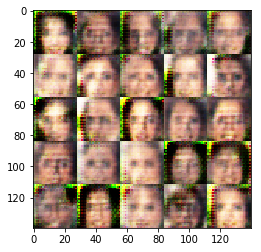

Epoch 0/1--- Batch 820---- Discriminator loss: 1.1655--- Generator loss: 0.9987---
Epoch 0/1--- Batch 840---- Discriminator loss: 1.0426--- Generator loss: 1.1301---
Epoch 0/1--- Batch 860---- Discriminator loss: 1.1353--- Generator loss: 1.0873---
Epoch 0/1--- Batch 880---- Discriminator loss: 1.1858--- Generator loss: 1.3183---
Epoch 0/1--- Batch 900---- Discriminator loss: 1.1438--- Generator loss: 0.9313---


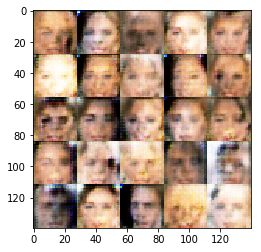

Epoch 0/1--- Batch 920---- Discriminator loss: 1.2036--- Generator loss: 1.1032---
Epoch 0/1--- Batch 940---- Discriminator loss: 1.1849--- Generator loss: 1.1438---
Epoch 0/1--- Batch 960---- Discriminator loss: 1.1083--- Generator loss: 1.1533---
Epoch 0/1--- Batch 980---- Discriminator loss: 1.3140--- Generator loss: 0.7655---
Epoch 0/1--- Batch 1000---- Discriminator loss: 1.2145--- Generator loss: 1.3377---


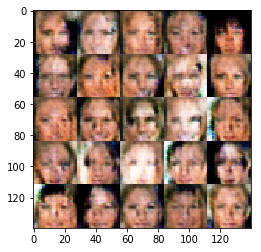

Epoch 0/1--- Batch 1020---- Discriminator loss: 1.1764--- Generator loss: 0.9066---
Epoch 0/1--- Batch 1040---- Discriminator loss: 1.2116--- Generator loss: 1.0265---
Epoch 0/1--- Batch 1060---- Discriminator loss: 1.1103--- Generator loss: 1.0040---
Epoch 0/1--- Batch 1080---- Discriminator loss: 1.1642--- Generator loss: 1.0670---
Epoch 0/1--- Batch 1100---- Discriminator loss: 1.2549--- Generator loss: 0.8462---


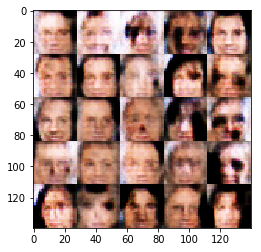

Epoch 0/1--- Batch 1120---- Discriminator loss: 1.2980--- Generator loss: 0.9894---
Epoch 0/1--- Batch 1140---- Discriminator loss: 1.1718--- Generator loss: 0.9218---
Epoch 0/1--- Batch 1160---- Discriminator loss: 1.2433--- Generator loss: 1.0301---
Epoch 0/1--- Batch 1180---- Discriminator loss: 1.2741--- Generator loss: 0.9609---
Epoch 0/1--- Batch 1200---- Discriminator loss: 1.2575--- Generator loss: 0.8638---


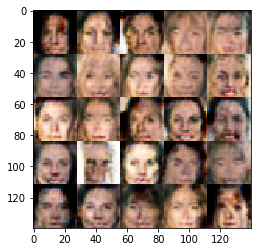

Epoch 0/1--- Batch 1220---- Discriminator loss: 1.2058--- Generator loss: 1.2157---
Epoch 0/1--- Batch 1240---- Discriminator loss: 1.1486--- Generator loss: 0.9819---
Epoch 0/1--- Batch 1260---- Discriminator loss: 1.2384--- Generator loss: 0.9423---
Epoch 0/1--- Batch 1280---- Discriminator loss: 1.3236--- Generator loss: 1.2529---
Epoch 0/1--- Batch 1300---- Discriminator loss: 1.2218--- Generator loss: 1.2771---


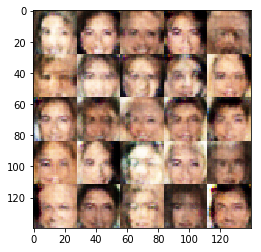

Epoch 0/1--- Batch 1320---- Discriminator loss: 1.2329--- Generator loss: 0.8489---
Epoch 0/1--- Batch 1340---- Discriminator loss: 1.2544--- Generator loss: 1.0393---
Epoch 0/1--- Batch 1360---- Discriminator loss: 1.3047--- Generator loss: 0.9679---
Epoch 0/1--- Batch 1380---- Discriminator loss: 1.2635--- Generator loss: 0.8053---
Epoch 0/1--- Batch 1400---- Discriminator loss: 1.1968--- Generator loss: 0.8783---


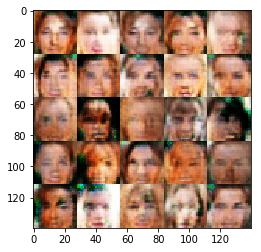

Epoch 0/1--- Batch 1420---- Discriminator loss: 1.2542--- Generator loss: 0.8956---
Epoch 0/1--- Batch 1440---- Discriminator loss: 0.7794--- Generator loss: 1.4963---
Epoch 0/1--- Batch 1460---- Discriminator loss: 1.2543--- Generator loss: 0.9960---
Epoch 0/1--- Batch 1480---- Discriminator loss: 1.3352--- Generator loss: 0.7883---
Epoch 0/1--- Batch 1500---- Discriminator loss: 1.3121--- Generator loss: 0.8526---


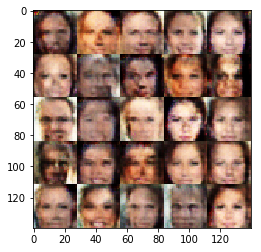

Epoch 0/1--- Batch 1520---- Discriminator loss: 1.2319--- Generator loss: 0.9751---
Epoch 0/1--- Batch 1540---- Discriminator loss: 1.2563--- Generator loss: 1.0509---
Epoch 0/1--- Batch 1560---- Discriminator loss: 1.2935--- Generator loss: 0.9144---
Epoch 0/1--- Batch 1580---- Discriminator loss: 1.2206--- Generator loss: 0.8299---
Epoch 0/1--- Batch 1600---- Discriminator loss: 1.2089--- Generator loss: 0.9767---


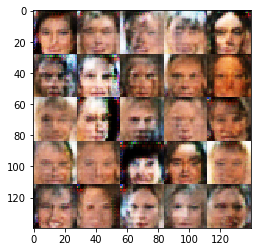

Epoch 0/1--- Batch 1620---- Discriminator loss: 1.2067--- Generator loss: 1.0028---
Epoch 0/1--- Batch 1640---- Discriminator loss: 1.2665--- Generator loss: 0.8705---
Epoch 0/1--- Batch 1660---- Discriminator loss: 1.2742--- Generator loss: 1.0712---
Epoch 0/1--- Batch 1680---- Discriminator loss: 1.2395--- Generator loss: 1.0506---
Epoch 0/1--- Batch 1700---- Discriminator loss: 1.2178--- Generator loss: 1.0621---


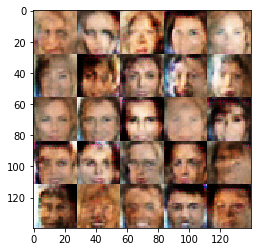

Epoch 0/1--- Batch 1720---- Discriminator loss: 1.2874--- Generator loss: 0.9273---
Epoch 0/1--- Batch 1740---- Discriminator loss: 1.2353--- Generator loss: 1.1925---
Epoch 0/1--- Batch 1760---- Discriminator loss: 1.2577--- Generator loss: 0.9914---
Epoch 0/1--- Batch 1780---- Discriminator loss: 1.2329--- Generator loss: 0.9658---
Epoch 0/1--- Batch 1800---- Discriminator loss: 1.2221--- Generator loss: 1.0263---


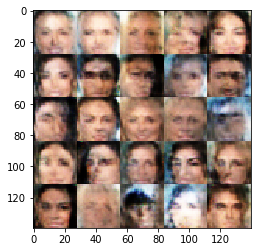

Epoch 0/1--- Batch 1820---- Discriminator loss: 1.2402--- Generator loss: 0.8231---
Epoch 0/1--- Batch 1840---- Discriminator loss: 1.3470--- Generator loss: 0.8316---
Epoch 0/1--- Batch 1860---- Discriminator loss: 1.2914--- Generator loss: 0.8729---
Epoch 0/1--- Batch 1880---- Discriminator loss: 1.3092--- Generator loss: 0.8966---
Epoch 0/1--- Batch 1900---- Discriminator loss: 1.2883--- Generator loss: 0.9853---


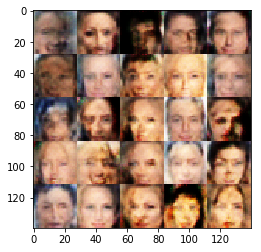

Epoch 0/1--- Batch 1920---- Discriminator loss: 1.2640--- Generator loss: 0.9484---
Epoch 0/1--- Batch 1940---- Discriminator loss: 1.3273--- Generator loss: 0.8498---
Epoch 0/1--- Batch 1960---- Discriminator loss: 1.2942--- Generator loss: 0.7490---
Epoch 0/1--- Batch 1980---- Discriminator loss: 1.3182--- Generator loss: 0.8897---
Epoch 0/1--- Batch 2000---- Discriminator loss: 1.2528--- Generator loss: 0.7678---


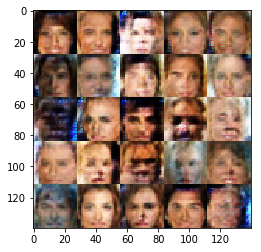

Epoch 0/1--- Batch 2020---- Discriminator loss: 1.2771--- Generator loss: 0.8168---
Epoch 0/1--- Batch 2040---- Discriminator loss: 1.3229--- Generator loss: 0.9295---
Epoch 0/1--- Batch 2060---- Discriminator loss: 1.2901--- Generator loss: 0.9207---
Epoch 0/1--- Batch 2080---- Discriminator loss: 1.2919--- Generator loss: 0.8110---
Epoch 0/1--- Batch 2100---- Discriminator loss: 1.3028--- Generator loss: 0.9104---


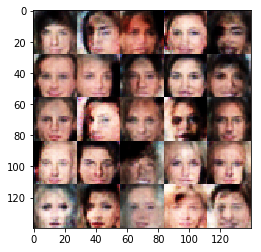

Epoch 0/1--- Batch 2120---- Discriminator loss: 1.2596--- Generator loss: 0.7816---
Epoch 0/1--- Batch 2140---- Discriminator loss: 1.2646--- Generator loss: 1.0195---
Epoch 0/1--- Batch 2160---- Discriminator loss: 1.3236--- Generator loss: 0.9109---
Epoch 0/1--- Batch 2180---- Discriminator loss: 1.2309--- Generator loss: 0.8810---
Epoch 0/1--- Batch 2200---- Discriminator loss: 1.3195--- Generator loss: 0.8757---


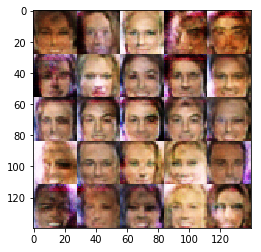

Epoch 0/1--- Batch 2220---- Discriminator loss: 1.3075--- Generator loss: 0.9595---
Epoch 0/1--- Batch 2240---- Discriminator loss: 1.3047--- Generator loss: 0.8084---
Epoch 0/1--- Batch 2260---- Discriminator loss: 1.3299--- Generator loss: 0.8685---
Epoch 0/1--- Batch 2280---- Discriminator loss: 1.3043--- Generator loss: 0.9085---
Epoch 0/1--- Batch 2300---- Discriminator loss: 1.3532--- Generator loss: 1.0022---


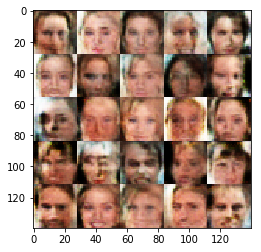

Epoch 0/1--- Batch 2320---- Discriminator loss: 1.2133--- Generator loss: 0.9735---
Epoch 0/1--- Batch 2340---- Discriminator loss: 1.3043--- Generator loss: 0.8440---
Epoch 0/1--- Batch 2360---- Discriminator loss: 1.2990--- Generator loss: 0.8226---
Epoch 0/1--- Batch 2380---- Discriminator loss: 1.3136--- Generator loss: 0.7388---
Epoch 0/1--- Batch 2400---- Discriminator loss: 1.3190--- Generator loss: 0.8513---


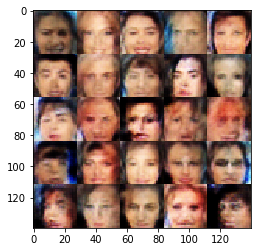

Epoch 0/1--- Batch 2420---- Discriminator loss: 1.2850--- Generator loss: 0.6358---
Epoch 0/1--- Batch 2440---- Discriminator loss: 1.2943--- Generator loss: 0.7725---
Epoch 0/1--- Batch 2460---- Discriminator loss: 1.3154--- Generator loss: 0.9209---
Epoch 0/1--- Batch 2480---- Discriminator loss: 1.3334--- Generator loss: 0.7571---
Epoch 0/1--- Batch 2500---- Discriminator loss: 1.2852--- Generator loss: 0.8807---


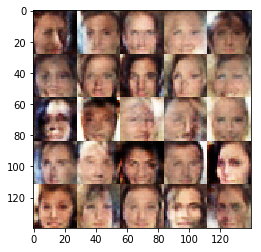

Epoch 0/1--- Batch 2520---- Discriminator loss: 1.3391--- Generator loss: 0.9552---
Epoch 0/1--- Batch 2540---- Discriminator loss: 1.2775--- Generator loss: 0.7837---
Epoch 0/1--- Batch 2560---- Discriminator loss: 1.3028--- Generator loss: 1.0869---
Epoch 0/1--- Batch 2580---- Discriminator loss: 1.2618--- Generator loss: 1.0502---
Epoch 0/1--- Batch 2600---- Discriminator loss: 1.3259--- Generator loss: 0.8006---


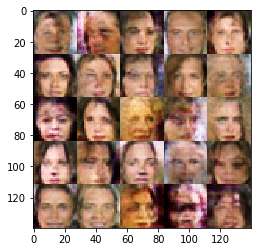

Epoch 0/1--- Batch 2620---- Discriminator loss: 1.3441--- Generator loss: 0.9256---
Epoch 0/1--- Batch 2640---- Discriminator loss: 1.3626--- Generator loss: 0.8804---
Epoch 0/1--- Batch 2660---- Discriminator loss: 1.3744--- Generator loss: 1.0711---
Epoch 0/1--- Batch 2680---- Discriminator loss: 1.1730--- Generator loss: 0.7500---
Epoch 0/1--- Batch 2700---- Discriminator loss: 1.2290--- Generator loss: 0.7348---


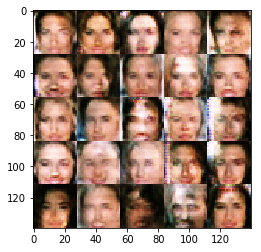

Epoch 0/1--- Batch 2720---- Discriminator loss: 1.2475--- Generator loss: 1.0610---
Epoch 0/1--- Batch 2740---- Discriminator loss: 1.3028--- Generator loss: 0.8328---
Epoch 0/1--- Batch 2760---- Discriminator loss: 1.3382--- Generator loss: 0.7138---
Epoch 0/1--- Batch 2780---- Discriminator loss: 1.3162--- Generator loss: 0.8768---
Epoch 0/1--- Batch 2800---- Discriminator loss: 1.3010--- Generator loss: 0.9087---


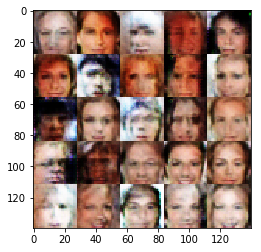

Epoch 0/1--- Batch 2820---- Discriminator loss: 1.3332--- Generator loss: 0.9326---
Epoch 0/1--- Batch 2840---- Discriminator loss: 1.3061--- Generator loss: 0.8347---
Epoch 0/1--- Batch 2860---- Discriminator loss: 1.3230--- Generator loss: 0.7889---
Epoch 0/1--- Batch 2880---- Discriminator loss: 1.4093--- Generator loss: 0.7636---
Epoch 0/1--- Batch 2900---- Discriminator loss: 1.2691--- Generator loss: 0.8561---


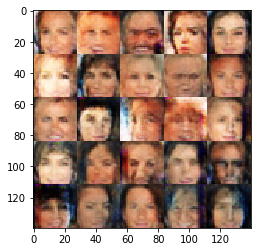

Epoch 0/1--- Batch 2920---- Discriminator loss: 1.3517--- Generator loss: 0.7167---
Epoch 0/1--- Batch 2940---- Discriminator loss: 1.2906--- Generator loss: 0.8721---
Epoch 0/1--- Batch 2960---- Discriminator loss: 1.2668--- Generator loss: 0.8213---
Epoch 0/1--- Batch 2980---- Discriminator loss: 1.3102--- Generator loss: 0.8132---
Epoch 0/1--- Batch 3000---- Discriminator loss: 1.2874--- Generator loss: 0.7715---


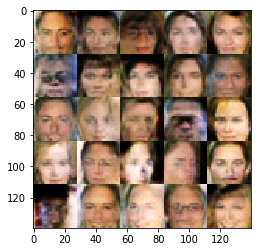

Epoch 0/1--- Batch 3020---- Discriminator loss: 1.3231--- Generator loss: 0.8513---
Epoch 0/1--- Batch 3040---- Discriminator loss: 1.3148--- Generator loss: 0.9180---
Epoch 0/1--- Batch 3060---- Discriminator loss: 1.3162--- Generator loss: 0.9816---
Epoch 0/1--- Batch 3080---- Discriminator loss: 1.3065--- Generator loss: 0.8233---
Epoch 0/1--- Batch 3100---- Discriminator loss: 1.2653--- Generator loss: 1.0786---


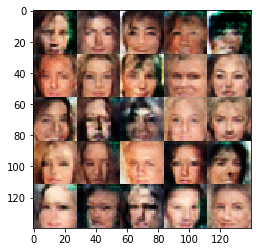

Epoch 0/1--- Batch 3120---- Discriminator loss: 1.3218--- Generator loss: 1.0611---
Epoch 0/1--- Batch 3140---- Discriminator loss: 1.3251--- Generator loss: 0.9914---
Epoch 0/1--- Batch 3160---- Discriminator loss: 1.3241--- Generator loss: 0.8256---
Epoch 0/1--- Batch 3180---- Discriminator loss: 1.3077--- Generator loss: 1.0028---
Epoch 0/1--- Batch 3200---- Discriminator loss: 1.3208--- Generator loss: 0.9897---


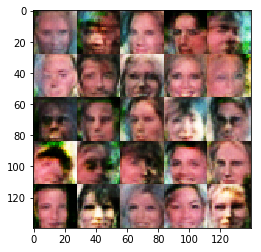

Epoch 0/1--- Batch 3220---- Discriminator loss: 1.3443--- Generator loss: 0.7925---
Epoch 0/1--- Batch 3240---- Discriminator loss: 1.3173--- Generator loss: 0.7614---
Epoch 0/1--- Batch 3260---- Discriminator loss: 1.2889--- Generator loss: 0.8557---
Epoch 0/1--- Batch 3280---- Discriminator loss: 1.2815--- Generator loss: 0.8762---
Epoch 0/1--- Batch 3300---- Discriminator loss: 1.3742--- Generator loss: 0.7454---


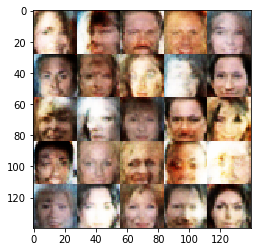

Epoch 0/1--- Batch 3320---- Discriminator loss: 1.3113--- Generator loss: 0.8280---
Epoch 0/1--- Batch 3340---- Discriminator loss: 1.2675--- Generator loss: 0.8754---
Epoch 0/1--- Batch 3360---- Discriminator loss: 1.2520--- Generator loss: 0.8749---
Epoch 0/1--- Batch 3380---- Discriminator loss: 1.2952--- Generator loss: 0.8365---
Epoch 0/1--- Batch 3400---- Discriminator loss: 1.3081--- Generator loss: 0.9731---


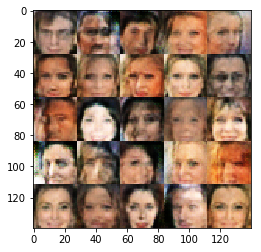

Epoch 0/1--- Batch 3420---- Discriminator loss: 1.3110--- Generator loss: 0.8796---
Epoch 0/1--- Batch 3440---- Discriminator loss: 1.3263--- Generator loss: 0.8426---
Epoch 0/1--- Batch 3460---- Discriminator loss: 1.3384--- Generator loss: 1.0144---
Epoch 0/1--- Batch 3480---- Discriminator loss: 1.3234--- Generator loss: 0.8894---
Epoch 0/1--- Batch 3500---- Discriminator loss: 1.3593--- Generator loss: 0.9191---


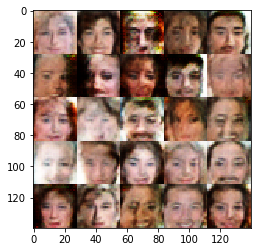

Epoch 0/1--- Batch 3520---- Discriminator loss: 1.3136--- Generator loss: 0.8203---
Epoch 0/1--- Batch 3540---- Discriminator loss: 1.3291--- Generator loss: 0.9917---
Epoch 0/1--- Batch 3560---- Discriminator loss: 1.3248--- Generator loss: 0.8011---
Epoch 0/1--- Batch 3580---- Discriminator loss: 1.3611--- Generator loss: 0.9014---
Epoch 0/1--- Batch 3600---- Discriminator loss: 1.3454--- Generator loss: 0.8142---


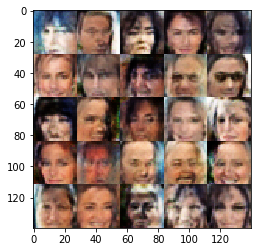

Epoch 0/1--- Batch 3620---- Discriminator loss: 1.3561--- Generator loss: 0.8617---
Epoch 0/1--- Batch 3640---- Discriminator loss: 1.3131--- Generator loss: 0.8245---
Epoch 0/1--- Batch 3660---- Discriminator loss: 1.3550--- Generator loss: 0.7584---
Epoch 0/1--- Batch 3680---- Discriminator loss: 1.3552--- Generator loss: 0.7675---
Epoch 0/1--- Batch 3700---- Discriminator loss: 1.3199--- Generator loss: 0.7947---


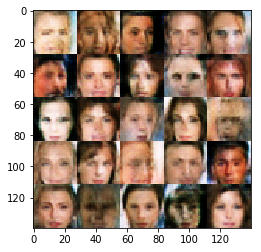

Epoch 0/1--- Batch 3720---- Discriminator loss: 1.3217--- Generator loss: 0.8090---
Epoch 0/1--- Batch 3740---- Discriminator loss: 1.3517--- Generator loss: 0.8452---
Epoch 0/1--- Batch 3760---- Discriminator loss: 1.3022--- Generator loss: 0.8788---
Epoch 0/1--- Batch 3780---- Discriminator loss: 1.3247--- Generator loss: 0.7653---
Epoch 0/1--- Batch 3800---- Discriminator loss: 1.3381--- Generator loss: 0.8148---


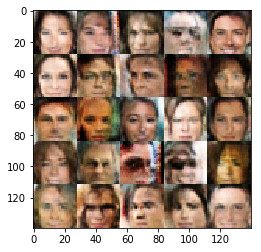

Epoch 0/1--- Batch 3820---- Discriminator loss: 1.3670--- Generator loss: 0.8425---
Epoch 0/1--- Batch 3840---- Discriminator loss: 1.3088--- Generator loss: 0.8424---
Epoch 0/1--- Batch 3860---- Discriminator loss: 1.2972--- Generator loss: 0.9059---
Epoch 0/1--- Batch 3880---- Discriminator loss: 1.3125--- Generator loss: 0.9149---
Epoch 0/1--- Batch 3900---- Discriminator loss: 1.3725--- Generator loss: 0.6908---


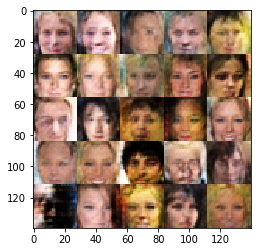

Epoch 0/1--- Batch 3920---- Discriminator loss: 1.3426--- Generator loss: 0.8458---
Epoch 0/1--- Batch 3940---- Discriminator loss: 1.3207--- Generator loss: 0.8471---
Epoch 0/1--- Batch 3960---- Discriminator loss: 1.3494--- Generator loss: 0.9368---
Epoch 0/1--- Batch 3980---- Discriminator loss: 1.3495--- Generator loss: 0.8042---
Epoch 0/1--- Batch 4000---- Discriminator loss: 1.3258--- Generator loss: 0.8434---


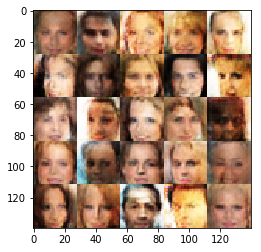

Epoch 0/1--- Batch 4020---- Discriminator loss: 1.3443--- Generator loss: 0.7870---
Epoch 0/1--- Batch 4040---- Discriminator loss: 1.3390--- Generator loss: 0.7852---
Epoch 0/1--- Batch 4060---- Discriminator loss: 1.3439--- Generator loss: 0.8729---
Epoch 0/1--- Batch 4080---- Discriminator loss: 1.2957--- Generator loss: 0.9139---
Epoch 0/1--- Batch 4100---- Discriminator loss: 1.3622--- Generator loss: 1.0306---


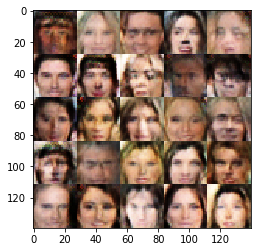

Epoch 0/1--- Batch 4120---- Discriminator loss: 1.3449--- Generator loss: 0.8674---
Epoch 0/1--- Batch 4140---- Discriminator loss: 1.3425--- Generator loss: 0.7498---
Epoch 0/1--- Batch 4160---- Discriminator loss: 1.3565--- Generator loss: 0.8714---
Epoch 0/1--- Batch 4180---- Discriminator loss: 1.3764--- Generator loss: 0.8476---
Epoch 0/1--- Batch 4200---- Discriminator loss: 1.3933--- Generator loss: 0.7599---


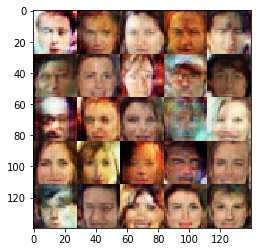

Epoch 0/1--- Batch 4220---- Discriminator loss: 1.3617--- Generator loss: 0.8200---
Epoch 0/1--- Batch 4240---- Discriminator loss: 1.4253--- Generator loss: 1.1599---
Epoch 0/1--- Batch 4260---- Discriminator loss: 1.3269--- Generator loss: 0.9153---
Epoch 0/1--- Batch 4280---- Discriminator loss: 1.3474--- Generator loss: 0.9112---
Epoch 0/1--- Batch 4300---- Discriminator loss: 1.3528--- Generator loss: 0.8581---


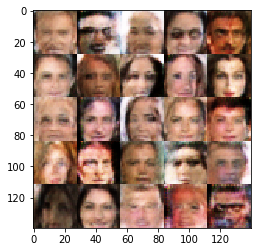

Epoch 0/1--- Batch 4320---- Discriminator loss: 1.3529--- Generator loss: 0.8071---
Epoch 0/1--- Batch 4340---- Discriminator loss: 1.3600--- Generator loss: 0.8909---
Epoch 0/1--- Batch 4360---- Discriminator loss: 1.3548--- Generator loss: 0.7852---
Epoch 0/1--- Batch 4380---- Discriminator loss: 1.3565--- Generator loss: 0.9726---
Epoch 0/1--- Batch 4400---- Discriminator loss: 1.3802--- Generator loss: 0.8318---


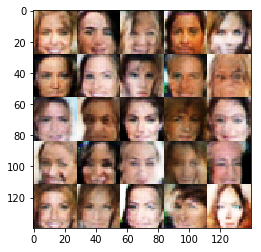

Epoch 0/1--- Batch 4420---- Discriminator loss: 1.3188--- Generator loss: 0.7135---
Epoch 0/1--- Batch 4440---- Discriminator loss: 1.3589--- Generator loss: 0.9463---
Epoch 0/1--- Batch 4460---- Discriminator loss: 1.3505--- Generator loss: 0.7486---
Epoch 0/1--- Batch 4480---- Discriminator loss: 1.3749--- Generator loss: 0.8437---
Epoch 0/1--- Batch 4500---- Discriminator loss: 1.3556--- Generator loss: 0.7579---


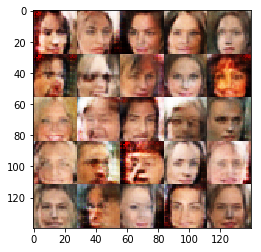

Epoch 0/1--- Batch 4520---- Discriminator loss: 1.3730--- Generator loss: 0.8918---
Epoch 0/1--- Batch 4540---- Discriminator loss: 1.3616--- Generator loss: 0.8269---
Epoch 0/1--- Batch 4560---- Discriminator loss: 1.3518--- Generator loss: 0.8308---
Epoch 0/1--- Batch 4580---- Discriminator loss: 1.3295--- Generator loss: 0.8289---
Epoch 0/1--- Batch 4600---- Discriminator loss: 1.3823--- Generator loss: 0.7721---


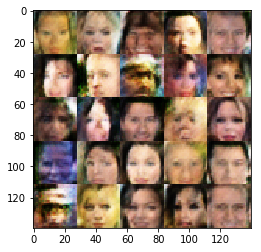

Epoch 0/1--- Batch 4620---- Discriminator loss: 1.3330--- Generator loss: 0.8104---
Epoch 0/1--- Batch 4640---- Discriminator loss: 1.3311--- Generator loss: 0.7864---
Epoch 0/1--- Batch 4660---- Discriminator loss: 1.3386--- Generator loss: 0.8346---
Epoch 0/1--- Batch 4680---- Discriminator loss: 1.3631--- Generator loss: 0.8994---
Epoch 0/1--- Batch 4700---- Discriminator loss: 1.3536--- Generator loss: 0.8064---


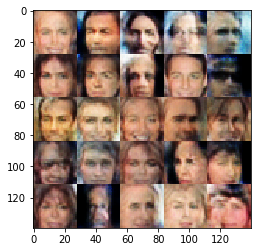

Epoch 0/1--- Batch 4720---- Discriminator loss: 1.3645--- Generator loss: 0.7450---
Epoch 0/1--- Batch 4740---- Discriminator loss: 1.3766--- Generator loss: 0.8604---
Epoch 0/1--- Batch 4760---- Discriminator loss: 1.3519--- Generator loss: 0.7608---
Epoch 0/1--- Batch 4780---- Discriminator loss: 1.3145--- Generator loss: 0.8081---
Epoch 0/1--- Batch 4800---- Discriminator loss: 1.3680--- Generator loss: 0.7920---


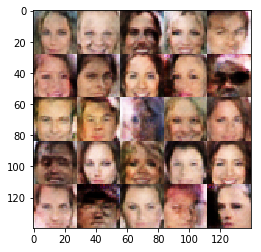

Epoch 0/1--- Batch 4820---- Discriminator loss: 1.3294--- Generator loss: 0.7592---
Epoch 0/1--- Batch 4840---- Discriminator loss: 1.3576--- Generator loss: 0.6901---
Epoch 0/1--- Batch 4860---- Discriminator loss: 1.3534--- Generator loss: 0.8517---
Epoch 0/1--- Batch 4880---- Discriminator loss: 1.3893--- Generator loss: 0.8594---
Epoch 0/1--- Batch 4900---- Discriminator loss: 1.3635--- Generator loss: 0.9097---


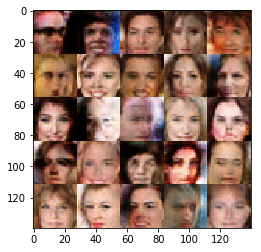

Epoch 0/1--- Batch 4920---- Discriminator loss: 1.3495--- Generator loss: 0.7837---
Epoch 0/1--- Batch 4940---- Discriminator loss: 1.3439--- Generator loss: 0.7947---
Epoch 0/1--- Batch 4960---- Discriminator loss: 1.3636--- Generator loss: 0.8779---
Epoch 0/1--- Batch 4980---- Discriminator loss: 1.3521--- Generator loss: 0.8019---
Epoch 0/1--- Batch 5000---- Discriminator loss: 1.3438--- Generator loss: 0.8762---


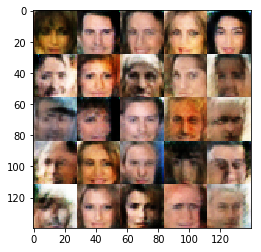

Epoch 0/1--- Batch 5020---- Discriminator loss: 1.3839--- Generator loss: 0.7594---
Epoch 0/1--- Batch 5040---- Discriminator loss: 1.3714--- Generator loss: 0.9445---
Epoch 0/1--- Batch 5060---- Discriminator loss: 1.4145--- Generator loss: 0.5724---
Epoch 0/1--- Batch 5080---- Discriminator loss: 1.3616--- Generator loss: 0.8495---
Epoch 0/1--- Batch 5100---- Discriminator loss: 1.3631--- Generator loss: 0.8810---


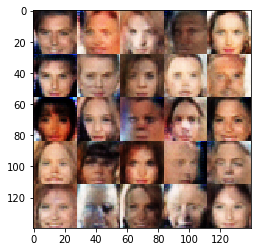

Epoch 0/1--- Batch 5120---- Discriminator loss: 1.2988--- Generator loss: 0.8959---
Epoch 0/1--- Batch 5140---- Discriminator loss: 1.4009--- Generator loss: 0.7266---
Epoch 0/1--- Batch 5160---- Discriminator loss: 1.3705--- Generator loss: 0.9785---
Epoch 0/1--- Batch 5180---- Discriminator loss: 1.3465--- Generator loss: 0.7953---
Epoch 0/1--- Batch 5200---- Discriminator loss: 1.3399--- Generator loss: 0.8544---


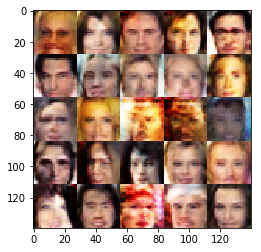

Epoch 0/1--- Batch 5220---- Discriminator loss: 1.3750--- Generator loss: 0.9056---
Epoch 0/1--- Batch 5240---- Discriminator loss: 1.3671--- Generator loss: 0.9228---
Epoch 0/1--- Batch 5260---- Discriminator loss: 1.3454--- Generator loss: 0.7672---
Epoch 0/1--- Batch 5280---- Discriminator loss: 1.3375--- Generator loss: 0.8351---
Epoch 0/1--- Batch 5300---- Discriminator loss: 1.3659--- Generator loss: 0.9609---


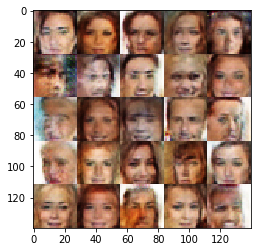

Epoch 0/1--- Batch 5320---- Discriminator loss: 1.3698--- Generator loss: 0.9106---
Epoch 0/1--- Batch 5340---- Discriminator loss: 1.3315--- Generator loss: 0.7778---
Epoch 0/1--- Batch 5360---- Discriminator loss: 1.3552--- Generator loss: 0.7409---
Epoch 0/1--- Batch 5380---- Discriminator loss: 1.3881--- Generator loss: 1.0099---
Epoch 0/1--- Batch 5400---- Discriminator loss: 1.3540--- Generator loss: 0.7148---


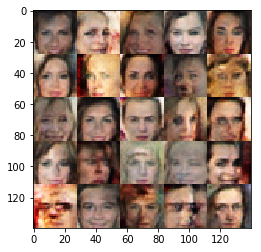

Epoch 0/1--- Batch 5420---- Discriminator loss: 1.3423--- Generator loss: 0.7931---
Epoch 0/1--- Batch 5440---- Discriminator loss: 1.3965--- Generator loss: 0.9001---
Epoch 0/1--- Batch 5460---- Discriminator loss: 1.3663--- Generator loss: 0.8238---
Epoch 0/1--- Batch 5480---- Discriminator loss: 1.3734--- Generator loss: 0.7353---
Epoch 0/1--- Batch 5500---- Discriminator loss: 1.3569--- Generator loss: 0.8823---


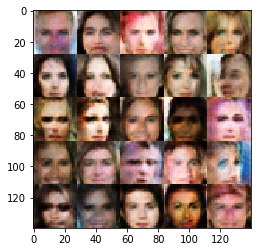

Epoch 0/1--- Batch 5520---- Discriminator loss: 1.3405--- Generator loss: 0.8400---
Epoch 0/1--- Batch 5540---- Discriminator loss: 1.3281--- Generator loss: 0.8029---
Epoch 0/1--- Batch 5560---- Discriminator loss: 1.3623--- Generator loss: 0.8682---
Epoch 0/1--- Batch 5580---- Discriminator loss: 1.3827--- Generator loss: 0.9218---
Epoch 0/1--- Batch 5600---- Discriminator loss: 1.3610--- Generator loss: 0.9317---


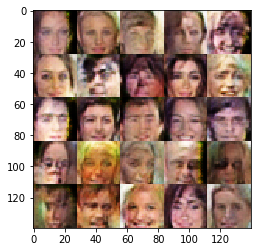

Epoch 0/1--- Batch 5620---- Discriminator loss: 1.3608--- Generator loss: 0.8439---
Epoch 0/1--- Batch 5640---- Discriminator loss: 1.3787--- Generator loss: 0.7567---
Epoch 0/1--- Batch 5660---- Discriminator loss: 1.3280--- Generator loss: 0.7409---
Epoch 0/1--- Batch 5680---- Discriminator loss: 1.4110--- Generator loss: 0.9308---
Epoch 0/1--- Batch 5700---- Discriminator loss: 1.3714--- Generator loss: 0.8308---


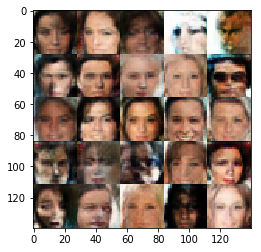

Epoch 0/1--- Batch 5720---- Discriminator loss: 1.3887--- Generator loss: 0.6745---
Epoch 0/1--- Batch 5740---- Discriminator loss: 1.3703--- Generator loss: 0.7130---
Epoch 0/1--- Batch 5760---- Discriminator loss: 1.3763--- Generator loss: 0.8294---
Epoch 0/1--- Batch 5780---- Discriminator loss: 1.3445--- Generator loss: 0.8081---
Epoch 0/1--- Batch 5800---- Discriminator loss: 1.3821--- Generator loss: 0.8726---


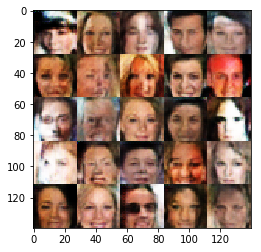

Epoch 0/1--- Batch 5820---- Discriminator loss: 1.3758--- Generator loss: 0.8610---
Epoch 0/1--- Batch 5840---- Discriminator loss: 1.3348--- Generator loss: 0.8431---
Epoch 0/1--- Batch 5860---- Discriminator loss: 1.3748--- Generator loss: 0.7753---
Epoch 0/1--- Batch 5880---- Discriminator loss: 1.3867--- Generator loss: 0.7621---
Epoch 0/1--- Batch 5900---- Discriminator loss: 1.3547--- Generator loss: 0.7927---


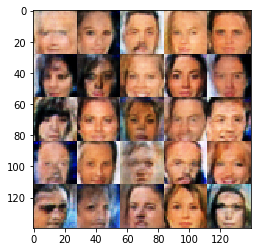

Epoch 0/1--- Batch 5920---- Discriminator loss: 1.3601--- Generator loss: 0.8971---
Epoch 0/1--- Batch 5940---- Discriminator loss: 1.3458--- Generator loss: 0.7181---
Epoch 0/1--- Batch 5960---- Discriminator loss: 1.4145--- Generator loss: 0.7436---
Epoch 0/1--- Batch 5980---- Discriminator loss: 1.3911--- Generator loss: 0.9015---
Epoch 0/1--- Batch 6000---- Discriminator loss: 1.3673--- Generator loss: 0.7999---


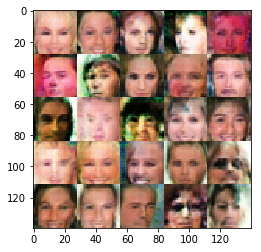

Epoch 0/1--- Batch 6020---- Discriminator loss: 1.3612--- Generator loss: 0.8820---
Epoch 0/1--- Batch 6040---- Discriminator loss: 1.3682--- Generator loss: 0.9091---
Epoch 0/1--- Batch 6060---- Discriminator loss: 1.3611--- Generator loss: 0.8171---
Epoch 0/1--- Batch 6080---- Discriminator loss: 1.3669--- Generator loss: 0.8742---
Epoch 0/1--- Batch 6100---- Discriminator loss: 1.3744--- Generator loss: 0.9523---


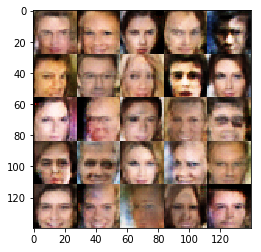

Epoch 0/1--- Batch 6120---- Discriminator loss: 1.3414--- Generator loss: 0.7960---
Epoch 0/1--- Batch 6140---- Discriminator loss: 1.3689--- Generator loss: 0.8688---
Epoch 0/1--- Batch 6160---- Discriminator loss: 1.3746--- Generator loss: 0.7890---
Epoch 0/1--- Batch 6180---- Discriminator loss: 1.3795--- Generator loss: 0.8410---
Epoch 0/1--- Batch 6200---- Discriminator loss: 1.3691--- Generator loss: 0.8443---


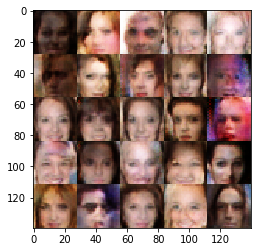

Epoch 0/1--- Batch 6220---- Discriminator loss: 1.3839--- Generator loss: 0.9072---
Epoch 0/1--- Batch 6240---- Discriminator loss: 1.3234--- Generator loss: 0.8000---
Epoch 0/1--- Batch 6260---- Discriminator loss: 1.4143--- Generator loss: 0.9875---
Epoch 0/1--- Batch 6280---- Discriminator loss: 1.3929--- Generator loss: 0.8172---
Epoch 0/1--- Batch 6300---- Discriminator loss: 1.3517--- Generator loss: 0.8779---


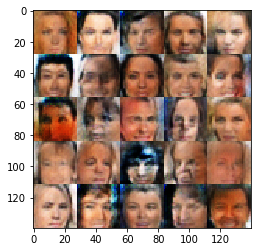

Epoch 0/1--- Batch 6320---- Discriminator loss: 1.3800--- Generator loss: 0.8118---


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.